# СБОРНЫЙ ПРОЕКТ № 2

Побудем в роли аналитка стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

**План исследования:**

- Обзор данных;
- Предобработка данных;
- Изучение и проверка данных;
- Исследование воронки событий;
- Анализ результатов экспериента.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Шаг 1.** Откроем файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as st
import math 
from plotly import graph_objects as go

In [2]:
pd.options.display.max_colwidth = 150

In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
pd.options.display.max_colwidth = 150
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датафрейме видим 5 столбца, по 244126 значений в каждом, пропущенных значений нет, колонку EventTimestamp требуется привести к временному типу, названия колонок приведем к нижнему регистру и змеиному стилю.

**Шаг 2. Предобработка данных**

In [6]:
# приведем названия столбцов к нижнему регистру и змеиному стилю
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 
                            'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

In [7]:
# проверим
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
# приведем event_timestamp к типу datetime
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [9]:
# проверим
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [10]:
# добавим столбец с датой
data['date'] = pd.to_datetime(data['event_timestamp'].dt.date)

In [11]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [12]:
# проверим на наличие дубликатов
data.duplicated().sum()

413

In [13]:
round(data.duplicated().sum()/len(data),4)

0.0017

In [14]:
data = data.drop_duplicates()

In [15]:
data.duplicated().sum()

0

In [52]:
double = data.duplicated(subset=['event_name', 'device_id_hash', 'event_timestamp'], keep=False)
data[double]

,event_name,device_id_hash,event_timestamp,exp_id,date


**В ходе предобработки данных было сделано следующее:**
- столбцы были приведены к нижнему регистру и змеиному стилю;
- столбец event_timestamp был приведен к временному типу;
- был создан столбец с датой - date;
- были удалены дубликаты;
- неявных дубликатов найдено не было;
Данные готовы к работе.

**Шаг 3. Изучим и проверим данные**

**3.1. Узнаем сколько всего событий в логе**

In [17]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

В логе 5 событий, самое большое кольчество в группе "MainScreenAppear" - 119101, наименьшее в "Tutorial" - 1018.

**3.2. Узнаем сколько всего пользователей в логе**

In [18]:
data['device_id_hash'].nunique()

7551

**3.3. Узнаем сколько в среднем событий приходится на пользователя**

In [19]:
event_by_user = data.groupby('device_id_hash')['event_name'].count()
event_by_user.mean()


32.27559263673685

In [20]:
event_by_user

device_id_hash
6888746892508752         1
6909561520679493         5
6922444491712477        47
7435777799948366         6
7702139951469979       137
                      ... 
9217594193087726423      9
9219463515465815368     17
9220879493065341500      7
9221926045299980007      7
9222603179720523844     59
Name: event_name, Length: 7551, dtype: int64

**3.4.1 Найдем максимальную и минимальную дату.**

In [21]:
# максимальная дата
data['date'].max()

Timestamp('2019-08-07 00:00:00')

In [22]:
#минимальная дата
data['date'].min()

Timestamp('2019-07-25 00:00:00')

In [23]:
# найдем период
data['event_timestamp'].max()-data['event_timestamp'].min()

Timedelta('13 days 16:31:41')

**3.4.2 Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп.**

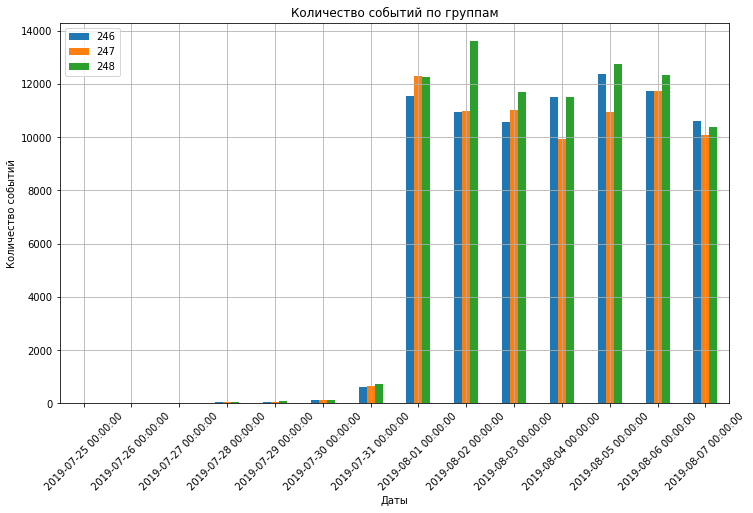

In [24]:
gr = data.pivot_table(index='date', columns='exp_id', values='device_id_hash', aggfunc='count').plot(
    kind='bar', figsize=(12,7), grid=True)
plt.xlabel('Даты') 
plt.ylabel('Количество событий') 
plt.title('Количество событий по группам') 
plt.legend() 
plt.xticks(rotation=45)
plt.show() 

По графику видно, что активность начитается с 1 августа 2019 года, до этого момента событий практически не было. Для анализа возьмем промежуток с 1 по 7 августа 2019 года.

In [25]:
interval_date = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
date_full = data[data['date'] >= interval_date]

**3.5. Узнаем много ли событий и пользователей мы потеряли, отбросив старые данные**

In [26]:
print('Количество потерянных событий:', len(data)-len(date_full))

print('Процент потерь событий:', round(100-len(date_full)/len(data)*100, 2), '%')

Количество потерянных событий: 2826
Процент потерь событий: 1.16 %


In [27]:
print('Количество потерянных пользователей:',data['device_id_hash'].nunique()-date_full['device_id_hash'].nunique())

print('Процент потерь пользователей:', round(100-date_full['device_id_hash'].nunique()/data['device_id_hash'].nunique()*100, 2), '%')

Количество потерянных пользователей: 17
Процент потерь пользователей: 0.23 %


Потери совсем небольшие, можно анализировать дальше.

**3.6. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.**

In [28]:
date_full['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

In [29]:
date_full.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

In [30]:
date_full.sample()

,event_name,device_id_hash,event_timestamp,exp_id,date
168414,MainScreenAppear,346062195302431477,2019-08-05 16:45:03,247,2019-08-05


In [31]:
# количество задублированных пользователей во всех группах 
data.groupby('device_id_hash').agg({'exp_id': 'nunique'}).query('exp_id>1').count()

exp_id    0
dtype: int64

По результатам видно, что присутствуют пользователи из всех трех экспериментальных групп, более того примерно по 2500 в каждой.

**Вывод:** Актуальными данные за период с 1 по 7 августа 2019 года. В них мы обнаружили всего 5 событий: главный экран, предложения, корзина, оплата и обучение. После обработки данных потери составили 1.16 % - для событий и 0.23 % для пользователей. Так как они несущественны, на дальнейший результат это не повлияет. Также в среднем на пользователя приходится примерно 32 события.

**Шаг 4. Изучим воронку событий**

**4.1. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте**

In [32]:
events_count = date_full['event_name'].value_counts().reset_index().sort_values(by='event_name', ascending=False)
events_count

,index,event_name
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Чаще всех встречается "MainScreenAppear", реже всего "Tutorial".

**4.2. Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.**

In [33]:
event_users = date_full.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).to_frame().reset_index()
event_users

,event_name,device_id_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [34]:
total_users = date_full['device_id_hash'].nunique()
total_users

7534

In [35]:
#добавим столбец с долей пользователей
event_users['percent'] = (event_users['device_id_hash'] / total_users).round(3) * 100 
event_users

,event_name,device_id_hash,percent
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


Больше всего пользователей посетило главный экран - 98.5%. Далее, на экран с предложениями переходили уже 61%. В корзину добавили 49.6% пользователей. Оплатили 47%, а прошли обучение всего 11.1%

**4.3 Подумаем, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Скорее всего пользователи начинают с главного экрана (MainScreenAppear), затем переходят в 'предложения' (OffersScreenAppear), если его заинтересовало что-то, то они отправляются в корзину (CartScreenAppear) и если все устроило, то он оплачивает покупку (PaymentScreenSuccessful). Еще есть также событие обучения (Tutorial), но видимо, приложение интуитивно понятное, что его пользователи пропускают, поэтому его можно и не учитывать при расчете воронки.

**4.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [36]:
event_users.drop([4], axis=0, inplace=True)

In [37]:
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = round(event_users.loc[i, 'device_id_hash'] / (event_users.loc[i-1, 'device_id_hash']),3) * 100

event_users

,event_name,device_id_hash,percent,funnel
0,MainScreenAppear,7419,98.5,1.0
1,OffersScreenAppear,4593,61.0,61.9
2,CartScreenAppear,3734,49.6,81.3
3,PaymentScreenSuccessful,3539,47.0,94.8


C MainScreenAppear на OffersScreenAppear переходят почти 62% пользователей, далее на CartScreenAppear переходят 81,3%, а уже на PaymentScreenSuccessful	переходят 94,8%

**4.5 Узнаем на каком шаге теряете больше всего пользователей**

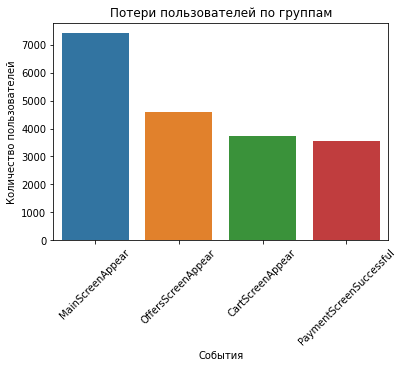

In [38]:
plt.figsize=(10,5)
sns.barplot(data=event_users.loc[0:4], x='event_name', y='device_id_hash')
plt.title('Потери пользователей по группам')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

По графику видно, что с перехода с главного экрана на экран предложений теряется больше всего пользователей.

**4.6 Узнаем какая доля пользователей доходит от первого события до оплаты**

In [39]:
event_users

,event_name,device_id_hash,percent,funnel
0,MainScreenAppear,7419,98.5,1.0
1,OffersScreenAppear,4593,61.0,61.9
2,CartScreenAppear,3734,49.6,81.3
3,PaymentScreenSuccessful,3539,47.0,94.8


In [40]:
round(event_users['device_id_hash'][3]/event_users['device_id_hash'][0]*100,1)

47.7

Из расчетов видно что почти 48% пользователей доходят до оплаты.

**Вывод по исследованию воронки событий:**
Всего пять типов событий в данных:
- MainScreenAppear;
- OffersScreenAppear;
- CartScreenAppear;
- PaymentScreenSuccessful.

Чаще всего из них встречается MainScreenAppear (появление главного экрана) - 117328 раз, реже всего - Tutorial (обучение) - 1005 раз.

По пользователям, которые соверишили эти события похожее распределение: больше всего у MainScreenAppear - 7419 пользователей и 98.5%, а у Tutorial - 840 пользователей и 11% cоответсвнно.

Мы предположили, что порядок событий должен быть таким: пользователи начинают с главного экрана (MainScreenAppear), затем переходят на экран с предложенными товарами (OffersScreenAppear), если его заинтересовало что-то, то он отправляется в корзину (CartScreenAppear) и когда его все устроило, то они оплачивают покупку (PaymentScreenSuccessful). Еще есть также событие обучения (Tutorial), но пользователи его скорее всего пропускают так как приложение интуитивно понятное, поэтому мы не учитывали при расчете воронки событий.

Около 62% пользователей переходят с MainScreenAppear на OffersScreenAppear, 81% переходят с OffersScreenAppear на CartScreenAppear, почти 95% переходят на шаг с CartScreenAppear на PaymentScreenSuccessful. Соответственно, 38% пользователей теряем при переходе с MainScreenAppear на OffersScreenAppear (Было 7419, осталось 4593), затем 19% с OffersScreenAppear на CartScreenAppear, и всего 5% с CartScreenAppear на PaymentScreenSuccessful.

С первого события (MainScreenAppear) до экрана оплаты (PaymentScreenSuccessful) доходят 47% пользователей (3539).

**Шаг 5. Изучим результаты эксперимента**

**5.1 Узнаем сколько пользователей в каждой экспериментальной группе**

In [41]:
date_full.groupby('exp_id')['device_id_hash'].nunique().to_frame()

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


В каждой экспериментальной группе примерно по 2500 пользователей.

**5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.**

In [42]:
group_246 = date_full.query('exp_id == 246').groupby('exp_id')['device_id_hash'].nunique().reset_index()
group_247 = date_full.query('exp_id == 247').groupby('exp_id')['device_id_hash'].nunique().reset_index()

In [43]:
group_246

,exp_id,device_id_hash
0,246,2484


In [44]:
group_247

,exp_id,device_id_hash
0,247,2513


In [45]:
round((1 - group_246['device_id_hash']/group_247['device_id_hash'])*100,2)

0    1.15
Name: device_id_hash, dtype: float64

Видно что разница совсем несущественная - чуть более 1 процента.

**5.3 Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

MainScreenAppear - самое популярное событие.

Сформулируем гипотезы:

Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть разница

In [46]:
def z_test(dataframe, num_group, alpha):
    #пользователи в каждой группе
    users = [dataframe.query('exp_id == @group')['device_id_hash'].nunique() for group in num_group]
    #перебор экспериментальных групп по событиям и количество пользователей
    for event in dataframe.event_name.unique():
        events = [dataframe.query('exp_id == %d and event_name == "%s"' % (group, event))['device_id_hash'].nunique() for group in num_group]
        
        p1 = events[0] / users[0] 
        p2 = events[1] / users[1] 
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 
        
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]))
        
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', event)
        print('p-значение: {p_value:}'.format(p_value=p_value))
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы')
            
        print('')    

In [47]:
z_test(date_full, [246, 247], 0.05)

Событие: Tutorial
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: MainScreenAppear
p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы



На каждом из этапов значимых статистических различий обнаружено не было.

**5.4. Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.**

In [48]:
z_test(date_full, [246, 248], 0.05)

Событие: Tutorial
p-значение: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: MainScreenAppear
p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы



Различия между группами 246 и 248, также, статистически не значимы

In [49]:
z_test(date_full, [247, 248], 0.05)

Событие: Tutorial
p-значение: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: MainScreenAppear
p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: CartScreenAppear
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы



Различия между группами 247 и 248 статистически не значимы

**Также сделаем тестрирование с объединенной контрольной группой.**

In [50]:
all_groups = date_full.copy()
all_groups['exp_id'].replace({247: 246}, inplace=True)

In [51]:
z_test(all_groups, [246, 248], 0.05)

Событие: Tutorial
p-значение: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: MainScreenAppear
p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: OffersScreenAppear
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: CartScreenAppear
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Событие: PaymentScreenSuccessful
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы



Значимых различий также не было обнаружено.

**Смена шрифта не повлияла на пользователей, так как статистические различия в тестах не значимы**

**5.5 Какой уровень значимости мы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если мы хотим изменить его, то проделаем предыдущие пункты и проверим свои выводы.**

Был выбран уровень значимости в 0.05. Всего было сделано 20 проверок статистических гипотез. Можно бы было воспользоваться методом Бонферрони для поправки значения p-value, в нашем случае его уменьшить следовало бы до 0.05/20=0.0025. Так как p-value был значительно больше 0.05, тоизменение шрифта не повлияло бы на пользователей.

**6. Вывод**

**Предобработка данных:**
- столбцы были приведены к нижнему регистру и змеиному стилю;
- столбец event_timestamp был приведен к временному типу;
- был создан столбец с датой - date;
- были удалены дубликаты;
- неявных дубликатов найдено не было;

**Изучение данных:**
Актуальными данные за период с 1 по 7 августа 2019 года. В них мы обнаружили всего 5 событий: главный экран, предложения, корзина, оплата и обучение. После обработки данных потери составили 1.16 % - для событий и 0.23 % для пользователей.
Так как они несущественны, на дальнейший результат это не повлияет. Также в среднем на пользователя приходится примерно 32 события.

**Исследование воронки событий:**
Всего пять типов событий в данных:
- MainScreenAppear;
- OffersScreenAppear;
- CartScreenAppear;
- PaymentScreenSuccessful.

Чаще всего из них встречается MainScreenAppear (появление главного экрана) - 117328 раз, реже всего - Tutorial (обучение) - 1005 раз.

По пользователям, которые соверишили эти события похожее распределение: больше всего у MainScreenAppear - 7419 пользователей и 98.5%, а у Tutorial - 840 пользователей и 11% cоответсвнно.

Мы предположили, что порядок событий должен быть таким: пользователи начинают с главного экрана (MainScreenAppear), затем переходят на экран с предложенными товарами (OffersScreenAppear), если его заинтересовало что-то, то он отправляется в корзину (CartScreenAppear) и когда его все устроило, то они оплачивают покупку (PaymentScreenSuccessful). Еще есть также событие обучения (Tutorial), но пользователи его скорее всего пропускают так как приложение интуитивно понятное, поэтому мы не учитывали при расчете воронки событий.

Около 62% пользователей переходят с MainScreenAppear на OffersScreenAppear, 81% переходят с OffersScreenAppear на CartScreenAppear, почти 95% переходят на шаг с CartScreenAppear на PaymentScreenSuccessful. Соответственно, 38% пользователей теряем при переходе с MainScreenAppear на OffersScreenAppear (Было 7419, осталось 4593), затем 19% с OffersScreenAppear на CartScreenAppear, и всего 5% с CartScreenAppear на PaymentScreenSuccessful.

С первого события (MainScreenAppear) до экрана оплаты (PaymentScreenSuccessful) доходят 47% пользователей (3539).

**Проверка результатов:**
Был выбран уровень значимости в 0.05. Всего было сделано 20 проверок статистических гипотез. Можно бы было воспользоваться методом Бонферрони для поправки значения p-value, в нашем случае его уменьшить следовало бы до 0.05/20=0.0025.
**Смена шрифта не повлияла на пользователей, так как статистические различия в тестах не значимы**